# NGC 6334 IN

MAGMAR paper:
https://ui.adsabs.harvard.edu/abs/2021ApJ...923..204C/abstract

Fig A1 of Sadhaghani gives names / locations

https://ui.adsabs.harvard.edu/abs/2020A%26A...635A...2S/abstract

Hunter+ 2014 might be better high-resolution work?

https://ui.adsabs.harvard.edu/abs/2014ApJ...788..187H/abstract

In [3]:
from astropy import units as u
distance = 1.3*u.kpc # Chibueze+2014
field = 'NGC6334IN'

In [4]:
cd /orange/adamginsburg/salt/sanhueza/NGC6334IN/

/orange/adamginsburg/salt/sanhueza/NGC6334IN


In [5]:
ls

abunchofregions.reg
IN_1.reg
IN_2
IN_3.reg
IN_3_sm.reg
NaCl_v_le_3_stackcube.fits
NGC_6334_I_N.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN2_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_small.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN1_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN2_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_small.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN1_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN2_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.imag

In [6]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b75d44281c0>

In [7]:
from astropy.table import Table
from astropy import table

In [8]:
import pprint

In [9]:
import scipy, scipy.ndimage

In [10]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [11]:
!cat IN_3_sm.reg

# Region file format: DS9 CARTA 2.0.0
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
box(260.227460, -35.754811, 0.3285", 0.2424", 52.125015) # color=#2EE6D6 width=2


In [12]:
import regions
from astropy import units as u, coordinates
sma6 = reg = regions.Regions.read('IN_3.reg')  # SMA6
regsm = regions.Regions.read('IN_3_sm.reg')  # SMA6
reg2 = regions.Regions.read('IN_2')
sma1bd = reg1 = regions.Regions.read('IN_1.reg')  #SMA1b/d
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [13]:
regsm[0].center.to_string('hmsdms')

'17h20m54.5904s -35d45m17.3196s'

In [14]:
for rr in (reg, regsm, reg2, reg1):
    print(rr[0].center.to_string('hmsdms'))

17h20m54.5952s -35d45m17.3628s
17h20m54.5904s -35d45m17.3196s
17h20m54.62808s -35d45m08.7516s
17h20m55.18368s -35d45m03.8556s


In [79]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
cat = Vizier(row_limit=1e5).get_catalogs('J/A+A/635/A2')[0]
sources = SkyCoord(cat['RAJ2000'], cat['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [80]:
import warnings
warnings.simplefilter('ignore')

SpectralCube with shape=(1, 5760, 5760) and unit=Jy / beam:
 n_x:   5760  type_x: RA---SIN  unit_x: deg    range:   260.219872 deg:  260.237614 deg
 n_y:   5760  type_y: DEC--SIN  unit_y: deg    range:   -35.759982 deg:  -35.745585 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 226150036676.700 Hz:226150036676.700 Hz

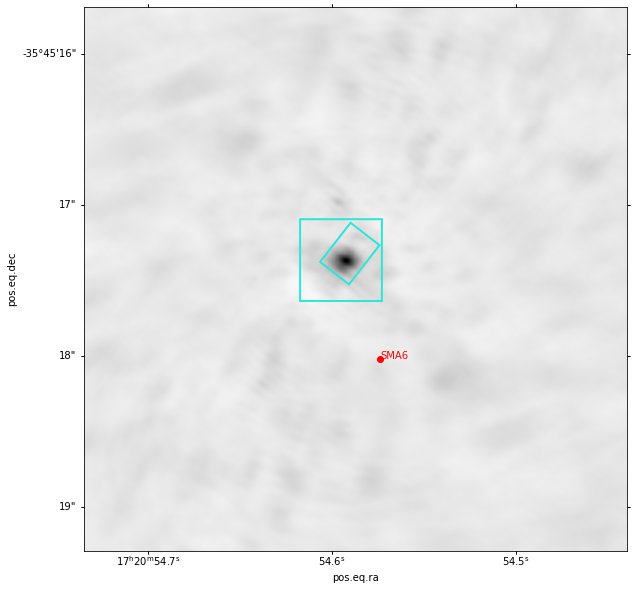

In [81]:
cont = SpectralCube.read('NGC_6334_I_N.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))

ww=cont[0].wcs
ww._naxis = cont[0].shape

ax = pl.subplot(projection=ww)
ax.imshow(cont[0].value, cmap='gray_r')
reg[0].to_pixel(ww).plot(ax=ax)
regsm[0].to_pixel(ww).plot(ax=ax)
ax.axis([3100,3500,1850,2250])
ax.scatter(sources.ra.deg, sources.dec.deg, c='r', transform=ax.get_transform('fk5'))
for row,src,ok in zip(cat, sources, ww.footprint_contains(sources)):
    if ok:
        txt = row['ONames'] or row['Seq']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')

    #ax.annotate(str(txt), (src.ra.deg, src.dec.deg), transform=ax.get_transform('fk5'), color='r')
    #ax.text(src.ra.deg, src.dec.deg, txt, transform=ax.get_transform('fk5'), color='r')
cont

# NaCl Stackl

In [82]:
from spectral_cube.analysis_utilities import stack_cube

In [83]:
nacltables = salt_tables[3:5]

In [84]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [85]:
flist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_small.fits'))

In [86]:
for fn in flist:
    for rr,regn in ((reg, 'IN3'), (reg1, 'IN1'), (reg2, 'IN2')):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
            cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(rr).to(u.K)
            cube.allow_huge_operations=True
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb)
            scube.to(u.K).write(outfile, overwrite=True)

In [87]:
regn = "IN3"
cubes = [SpectralCube.read(fn).subcube_from_regions(reg)
         for fn in (glob.glob(f'NGC_6334_I_N.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]

cubes

[SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562724480.800 Hz:235437314159.321 Hz,
 SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz,
 SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062723285.979 Hz:220937312964.500 Hz,
 SpectralCube with sha

In [88]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [89]:
cb

Beam: BMAJ=0.08480816000466052 arcsec BMIN=0.05179367686516083 arcsec BPA=68.21702794620528 deg

In [90]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 110.25060801 AU>

In [91]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 67.33177992 AU>

In [92]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [93]:
from astropy import log
log.setLevel('INFO')

In [94]:
#log.setLevel('DEBUG')
vcen = -5 * u.km/u.s # from Patricio, though maybe -8 km/s is better
vcen = 15*u.km/u.s # my by-eye check through the cubes in CARTA
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [95]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(91, 60, 60) and unit=K:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -35.216 km / s:      25.225 km / s

In [96]:
jtok = stackc.beam.jtok(217*u.GHz)

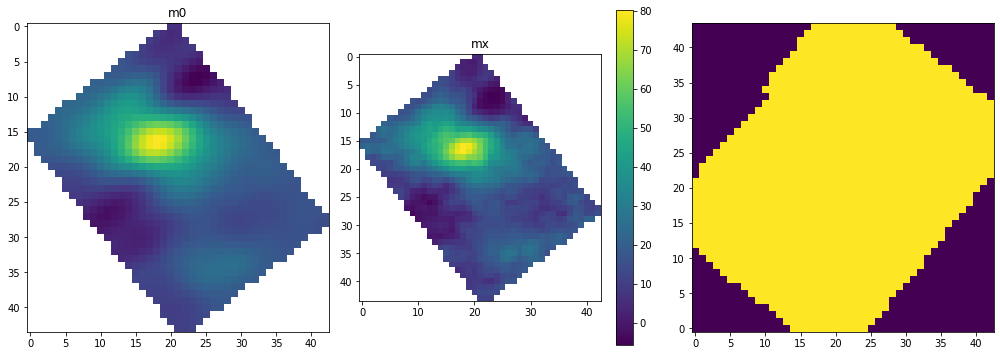

<Figure size 432x288 with 0 Axes>

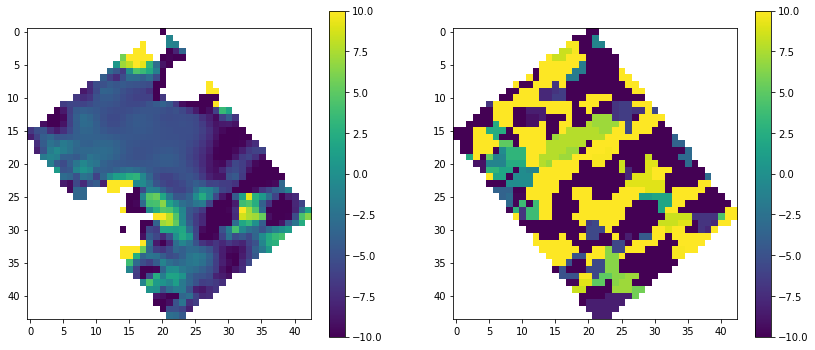

In [97]:
stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.00016*jtok
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0005*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


#vmap = m1.hdu

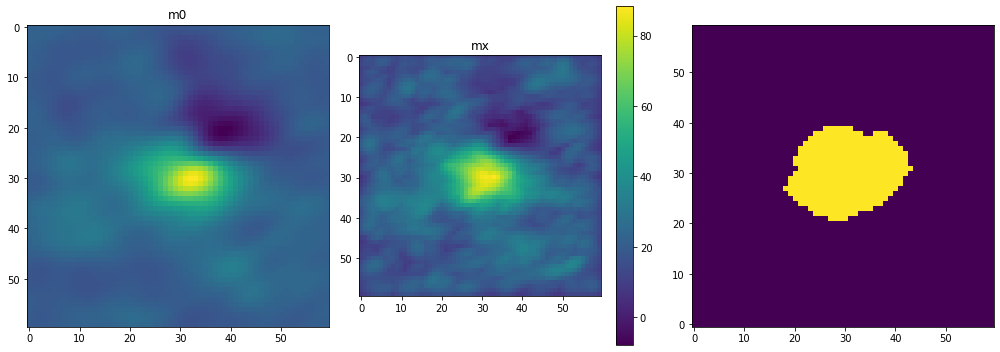

<Figure size 432x288 with 0 Axes>

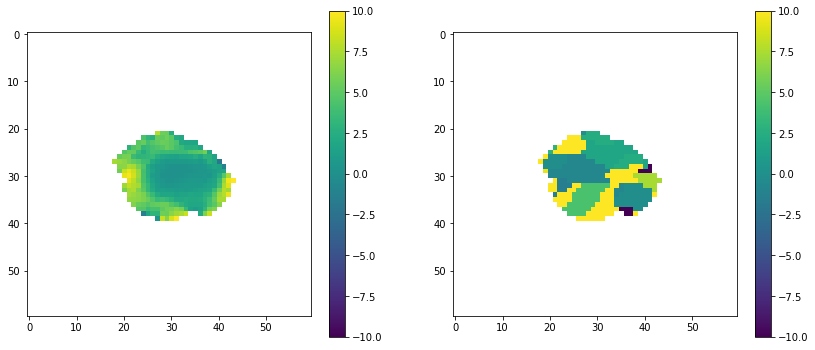

In [98]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
#restval = 217.886504*u.GHz # CH3OH 20-?
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 45*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()



m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [99]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [162]:
import imp
import overplot_saltlines
imp.reload(overplot_saltlines)
import lines
imp.reload(lines)
from overplot_saltlines import overplot_saltlines, all_lines
'SO65-54' in all_lines

True

In [163]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [164]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


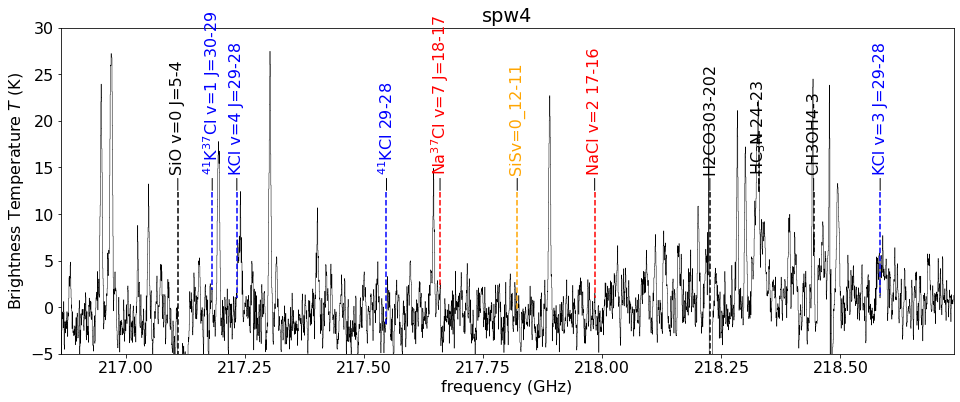

In [165]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures', ymin=-5, ymax=30)

In [166]:
from astroquery.splatalogue import Splatalogue

In [167]:
vcen

<Quantity -5. km / s>

217.88571237201717 GHz


<Table length=1>
  Species   Chemical Name Freq-GHz(rest frame,redshifted) Freq Err(rest frame,redshifted) Meas Freq-GHz(rest frame,redshifted) Meas Freq Err(rest frame,redshifted)        Resolved QNs       CDMS/JPL Intensity ... Lovas/AST Intensity E_L (cm^-1) E_L (K)  E_U (cm^-1)  E_U (K)  Upper State Degeneracy Linelist
   str11         str8                 float64                         float64                            int64                                int64                           str25                float64       ...        int64          float64   float64    float64    float64         float64           str4  
----------- ------------- ------------------------------- ------------------------------- ------------------------------------ ------------------------------------ ------------------------- ------------------ ... ------------------- ----------- -------- ----------- --------- ---------------------- --------
CH3OHvt=0-2      Methanol                      217.886504                         2.2e-05                                   --                                   -- 20(-1,19)-20(-0,20)E,vt=0            -4.1341 ...                  --    346.0728 497.9187   353.34071 508.37554                  164.0     CDMS

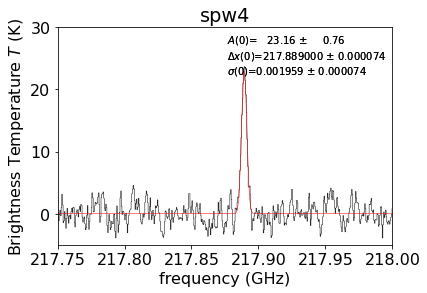

In [168]:
sp = spectra[3]
lx,ux = 217.75, 218.0
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=30)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
print(cen,)
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')

In [169]:
ls spectra/figures

color_labels_NGC_6334_I_N_spw0_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw0_stack.png
color_labels_NGC_6334_I_N_spw1_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw1_stack.png
color_labels_NGC_6334_I_N_spw2_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw2_stack.png
color_labels_NGC_6334_I_N_spw3_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
gallery.html
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.

In [170]:
from IPython.display import Image,display

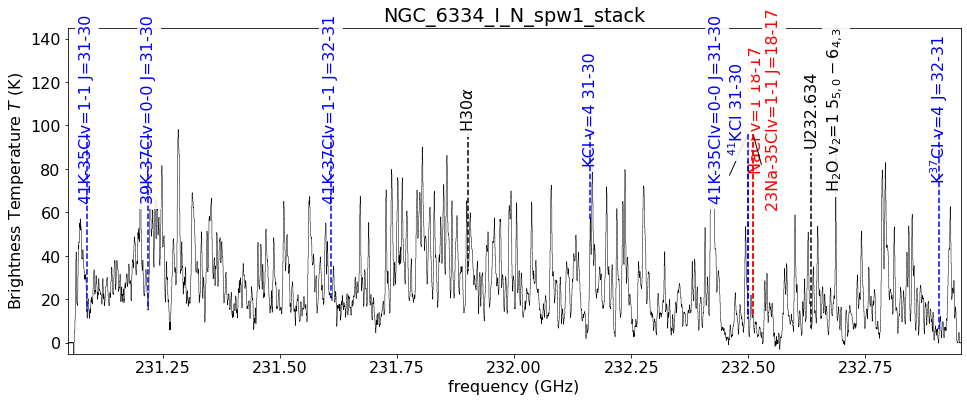

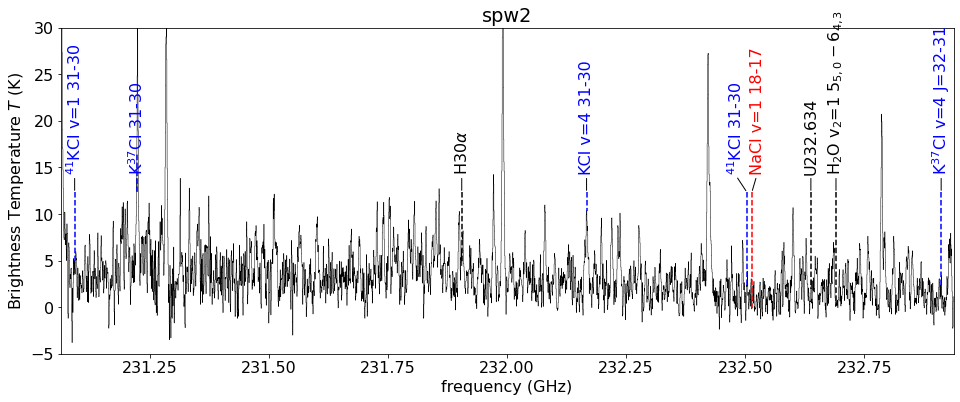

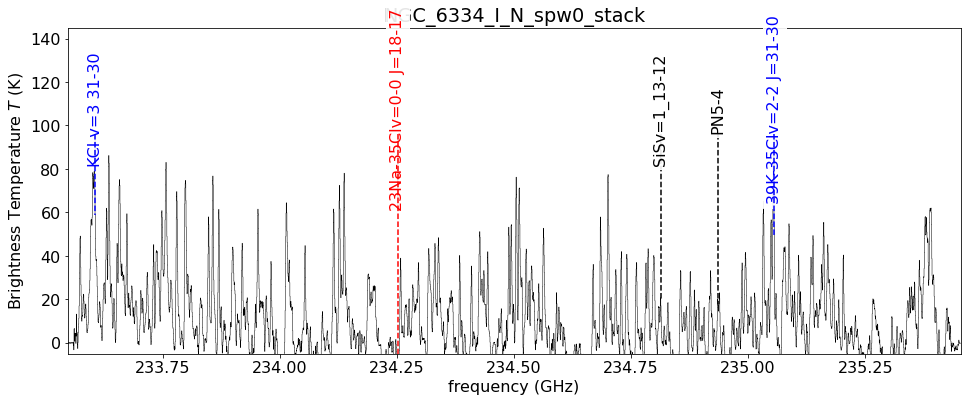

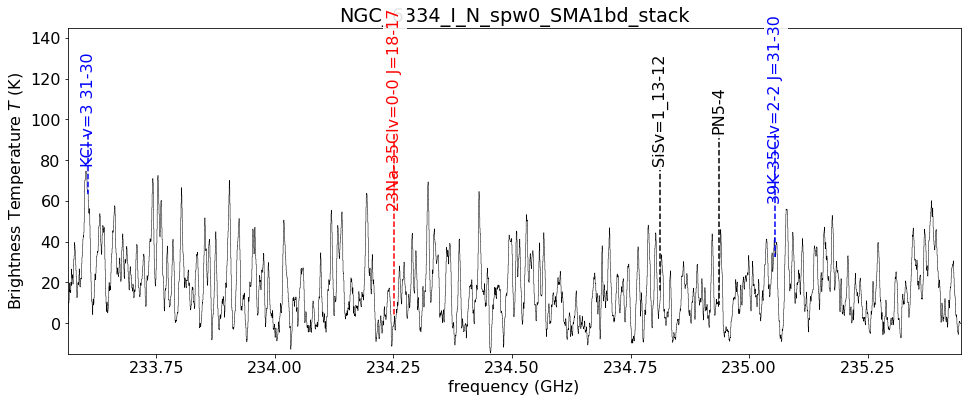

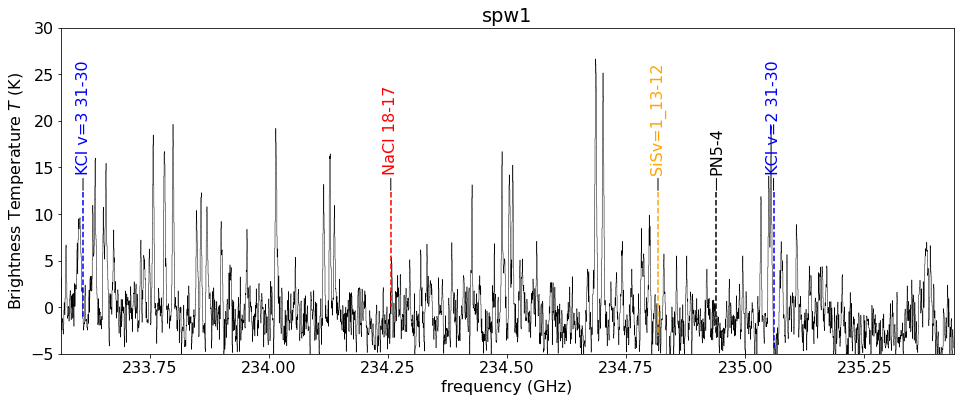

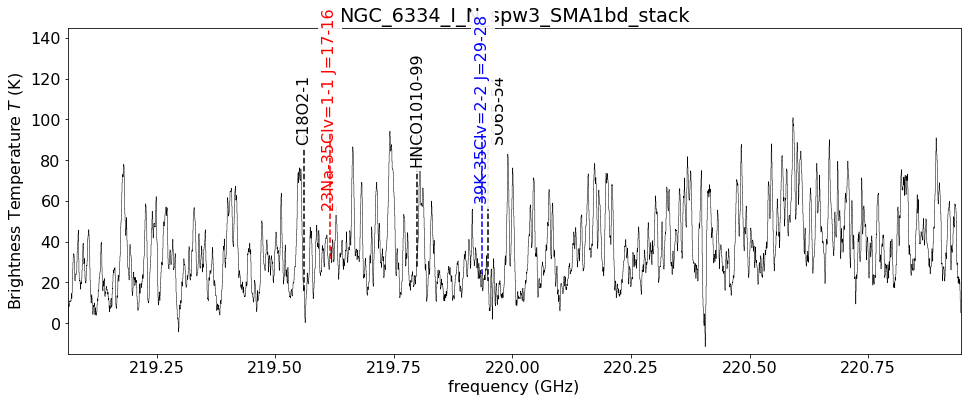

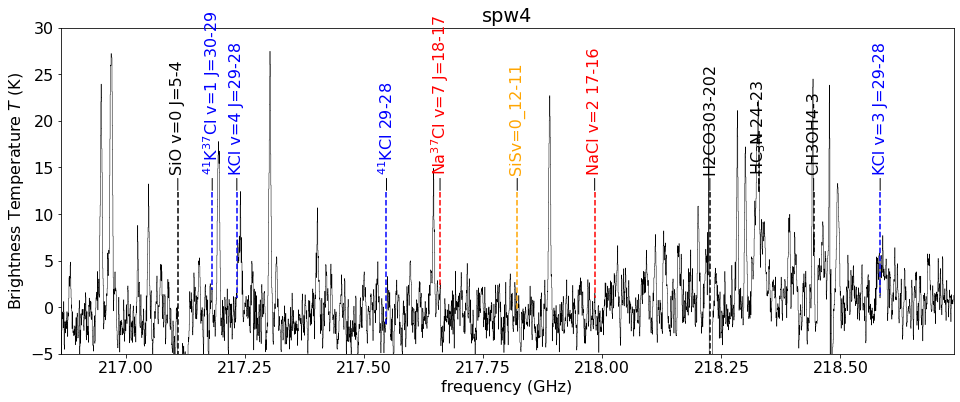

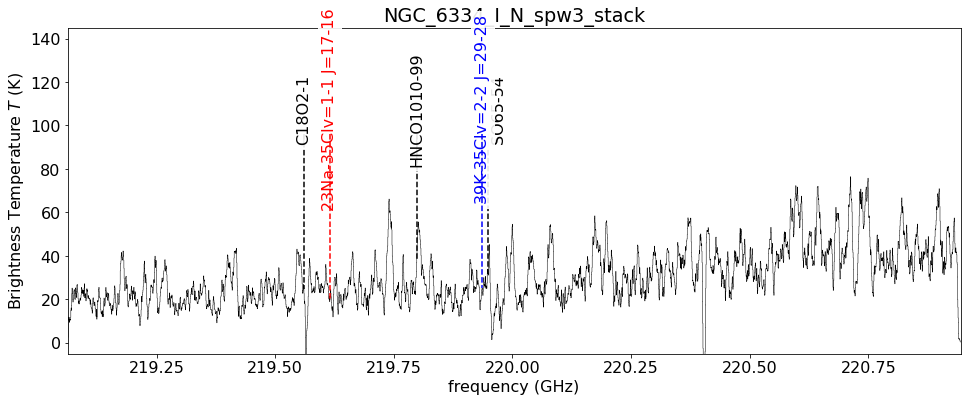

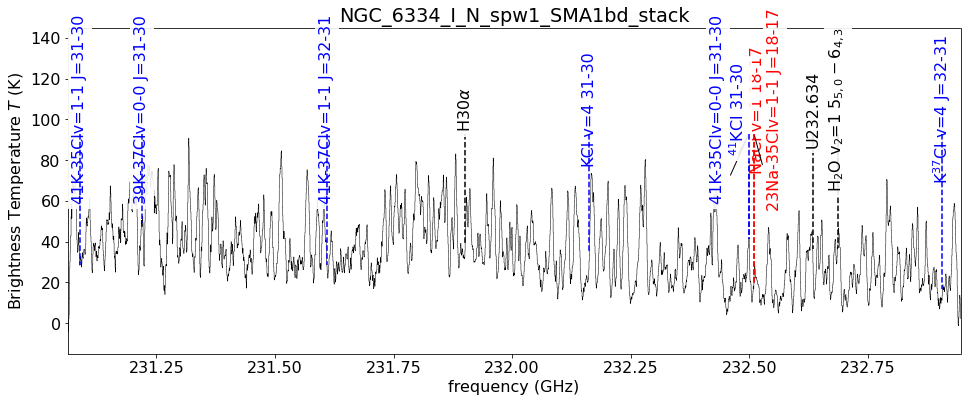

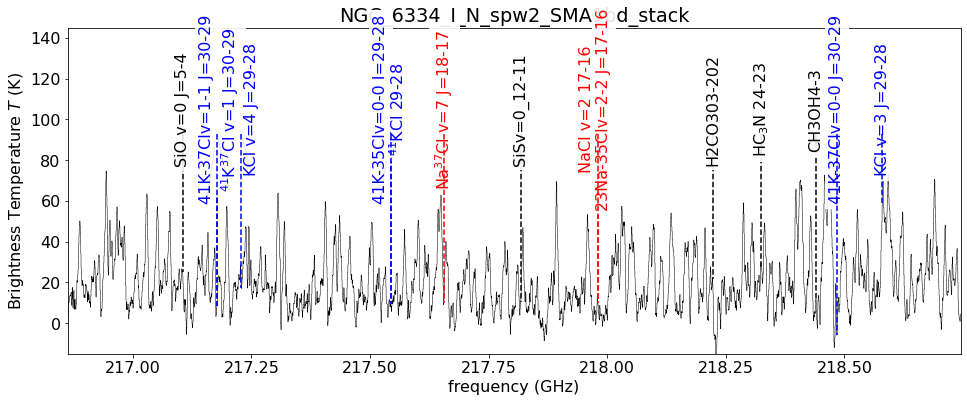

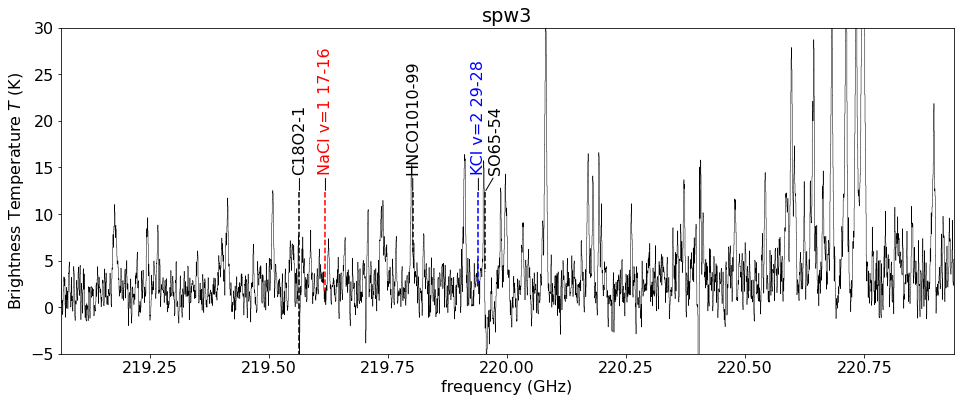

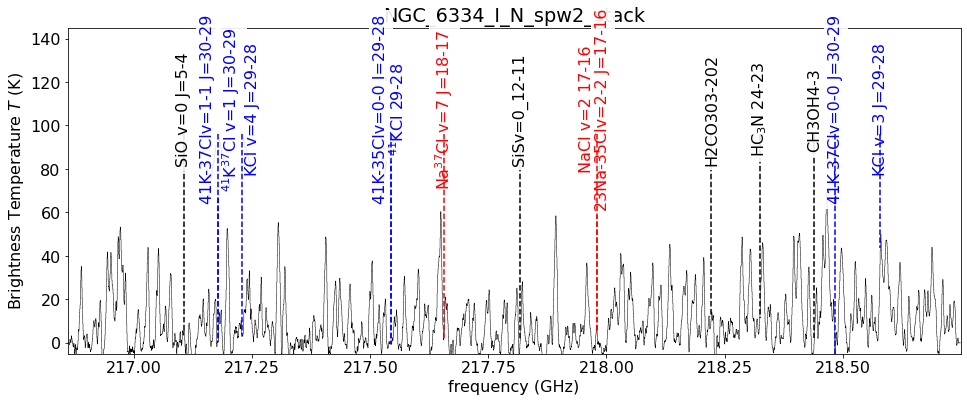

In [171]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [172]:
print("TEST")

TEST


DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562724480.800 Hz:235437314159.321 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:

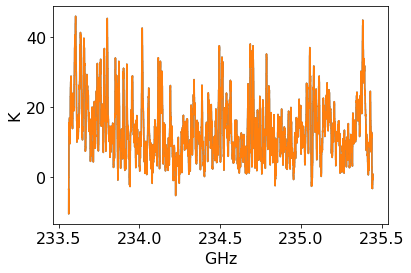

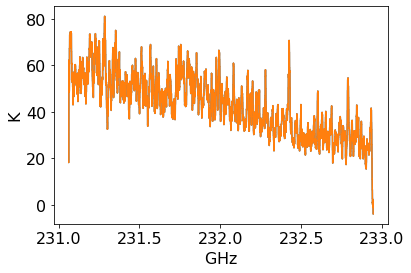

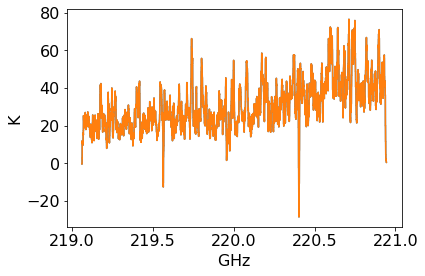

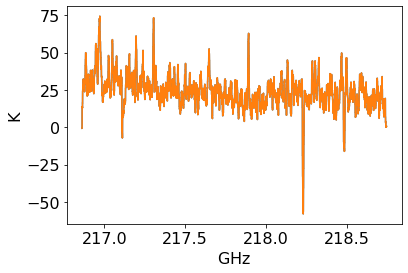

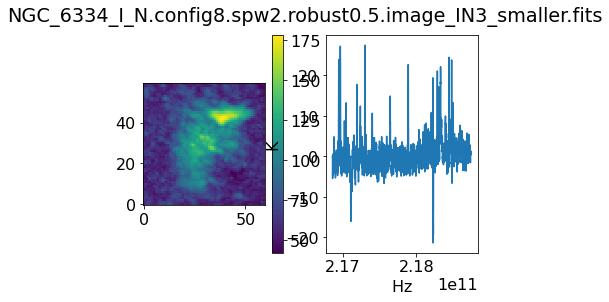

In [173]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

cbflist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_IN3_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_NGC6334INSMA6_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap.fits')
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_NGC6334INSMA6_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [174]:
ls spectra

figures/
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN1_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN1_smaller_SMA1bd_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN1_smalle

In [181]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    if pysp.unit != u.K:
        pysp.unit = u.K
        pysp.data *= jtok.value
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]} {spl[2]} stack'
    stackspectra.append(pysp)

NGC_6334_I_N_spw2_stack
NGC_6334_I_N_spw1_stack
NGC_6334_I_N_spw2_stack
NGC_6334_I_N_spw0_stack
NGC_6334_I_N_spw0_stack
NGC_6334_I_N_spw3_stack
NGC_6334_I_N_spw0_stack
NGC_6334_I_N_spw1_stack
NGC_6334_I_N_spw2_stack
NGC_6334_I_N_spw3_stack
NGC_6334_I_N_spw3_stack
NGC_6334_I_N_spw1_stack


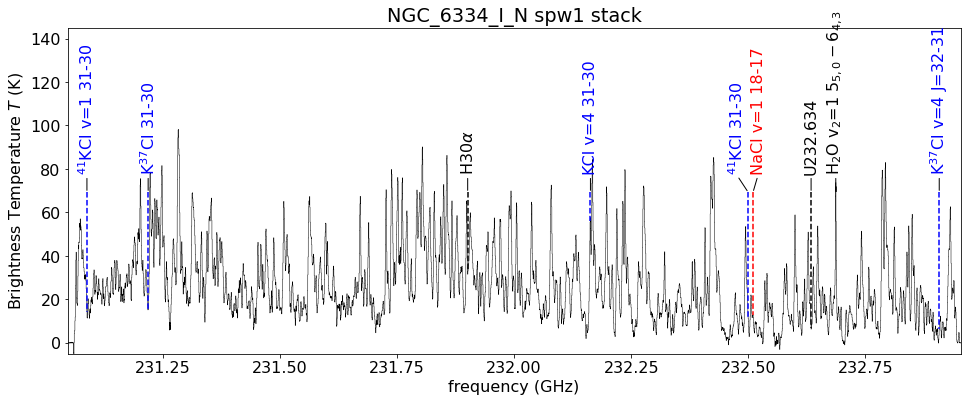

In [182]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-5, ymax=145)

In [183]:
ls spectra/figures/

color_labels_NGC_6334_I_N_spw0_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw0_stack.png
color_labels_NGC_6334_I_N_spw1_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw1_stack.png
color_labels_NGC_6334_I_N_spw2_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw2_stack.png
color_labels_NGC_6334_I_N_spw3_SMA1bd_stack.png
color_labels_NGC_6334_I_N_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
gallery.html
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.

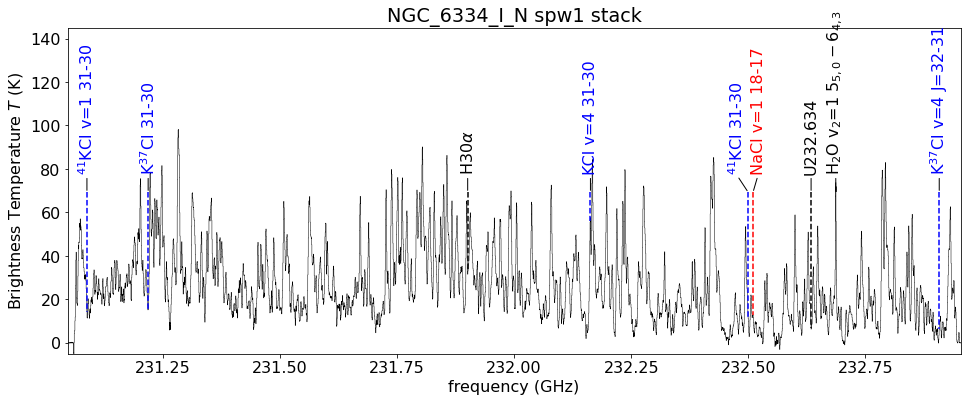

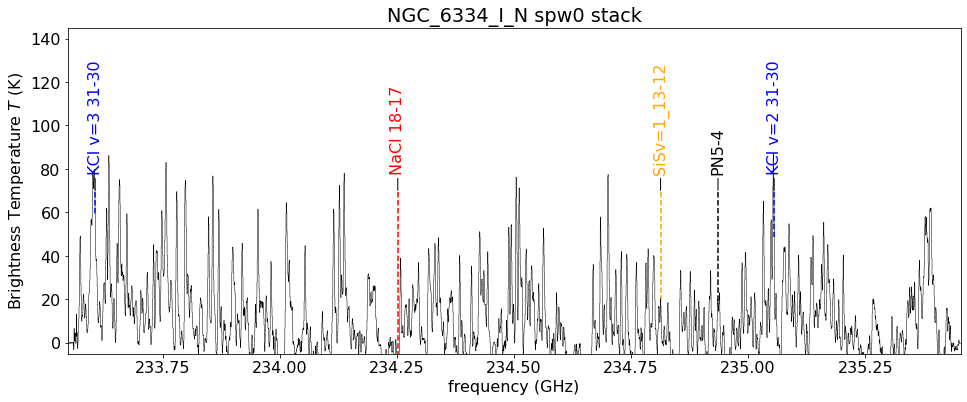

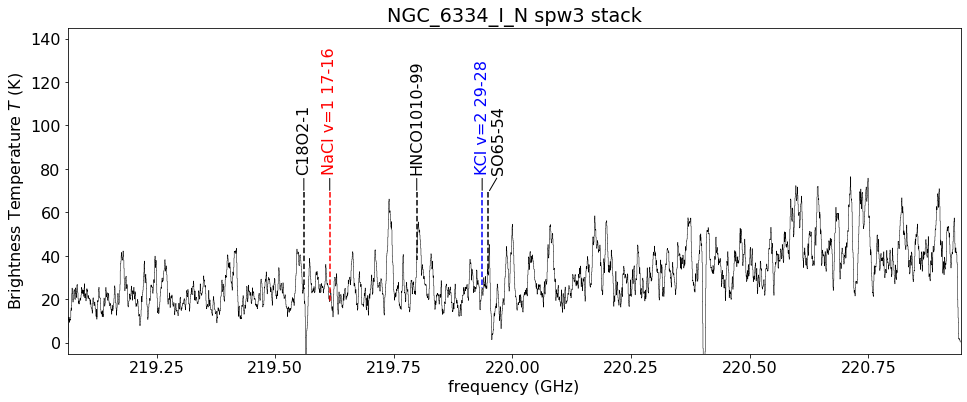

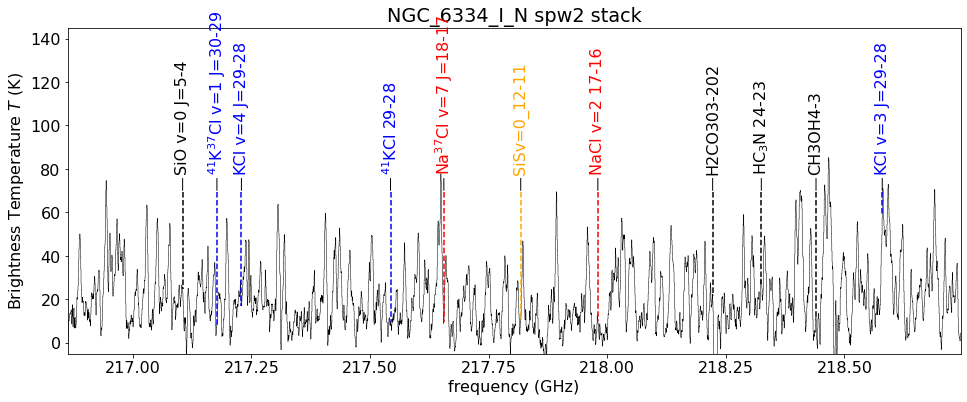

In [184]:
for fn in glob.glob('spectra/figures/color*spw[0-4]_stack.png'):
    display(Image(fn))

In [185]:
from astropy.stats import mad_std

In [186]:
for sp in stackspectra:
    print(sp.data.std(), mad_std(sp.data))

9.845037953807795 7.39610242596659
12.56688563046171 14.69251494871354
11.132328511746568 8.400784873860482
8.591860348394102 7.791100469951105
15.785268176643907 15.472382278418788
18.035482228362046 16.906323252212015
17.599394421471132 14.144509772207394
16.189096347000124 16.101416752671337
15.056741175290973 13.371136711955387
12.182142538722514 10.497387415860825
12.890275936641478 12.030197764134805
16.874596022619084 14.288191815726211


# IN 1

(2300.0, 2700.0, 3400.0, 3800.0)

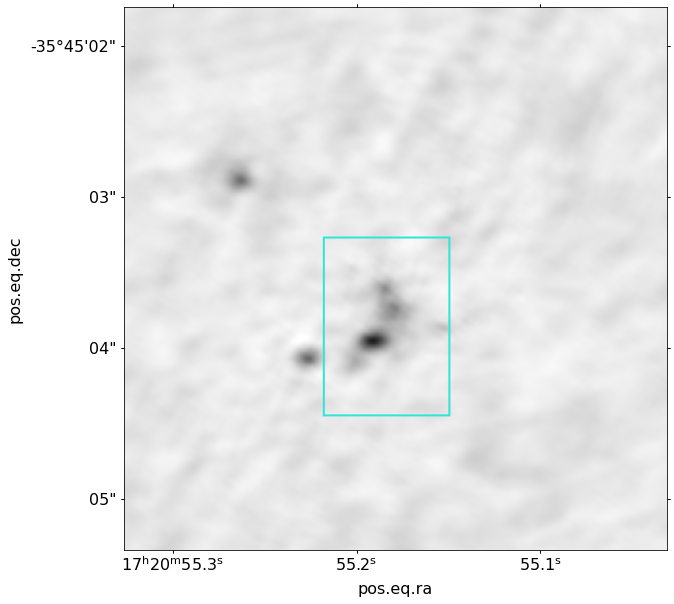

In [119]:
cont = SpectralCube.read('NGC_6334_I_N.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r')
reg1[0].to_pixel(cont[0].wcs).plot(ax=ax)
ax.axis([2300,2700,3400,3800])

SpectralCube with shape=(1, 5760, 5760) and unit=Jy / beam:
 n_x:   5760  type_x: RA---SIN  unit_x: deg    range:   260.219872 deg:  260.237614 deg
 n_y:   5760  type_y: DEC--SIN  unit_y: deg    range:   -35.759982 deg:  -35.745585 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 226150036676.700 Hz:226150036676.700 Hz

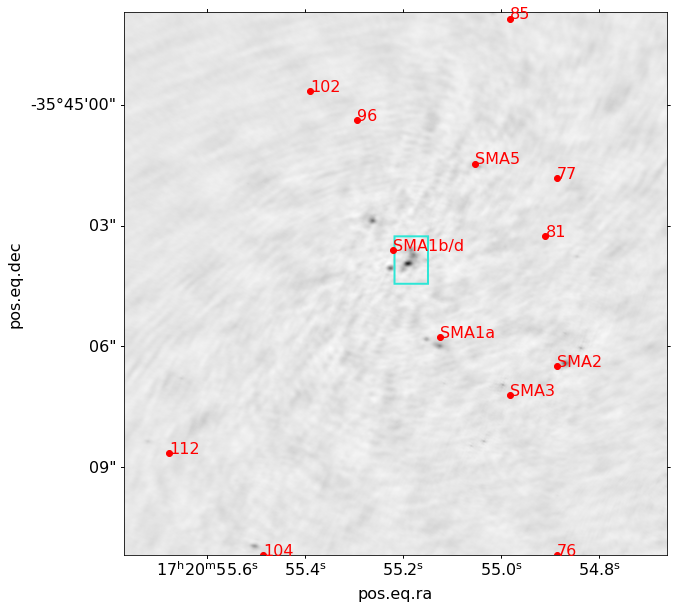

In [120]:
cont = SpectralCube.read('NGC_6334_I_N.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))

ww=cont[0].wcs
ww._naxis = cont[0].shape

ax = pl.subplot(projection=ww)
ax.imshow(cont[0].value, cmap='gray_r')
reg2[0].to_pixel(ww).plot(ax=ax)
reg1[0].to_pixel(ww).plot(ax=ax)
ax.axis([1700,3200,2750,4250])
ax.scatter(sources.ra.deg, sources.dec.deg, c='r', transform=ax.get_transform('fk5'))
for row,src,ok in zip(cat, sources, ww.footprint_contains(sources)):
    if ok:
        txt = row['ONames'] or row['Seq']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')

    #ax.annotate(str(txt), (src.ra.deg, src.dec.deg), transform=ax.get_transform('fk5'), color='r')
    #ax.text(src.ra.deg, src.dec.deg, txt, transform=ax.get_transform('fk5'), color='r')
cont

In [121]:
regn = "IN1"
cubes1 = [SpectralCube.read(fn).subcube_from_regions(reg1)
         for fn in (glob.glob(f'NGC_6334_I_N.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]

cubes1

[SpectralCube with shape=(3840, 131, 92) and unit=K:
  n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
  n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.751233 deg:  -35.750908 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz,
 SpectralCube with shape=(3840, 131, 92) and unit=K:
  n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
  n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.751233 deg:  -35.750908 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062723285.979 Hz:220937312964.500 Hz,
 SpectralCube with shape=(3840, 131, 92) and unit=K:
  n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
  n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.751233 deg:  -35.750908 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216862723104.779 Hz:218737312783.300 Hz,
 SpectralCube with 

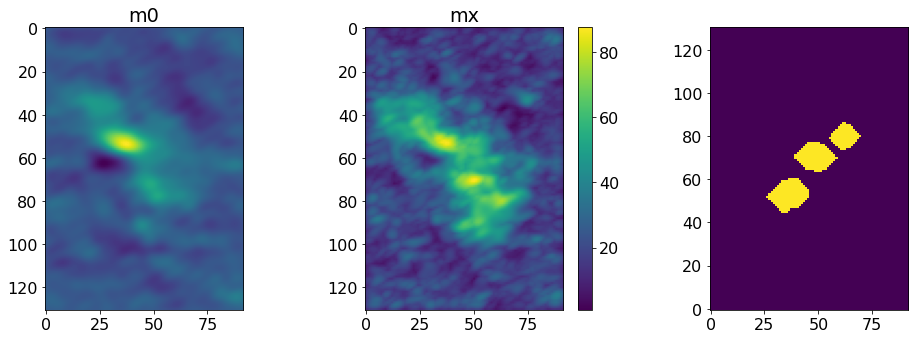

<Figure size 432x288 with 0 Axes>

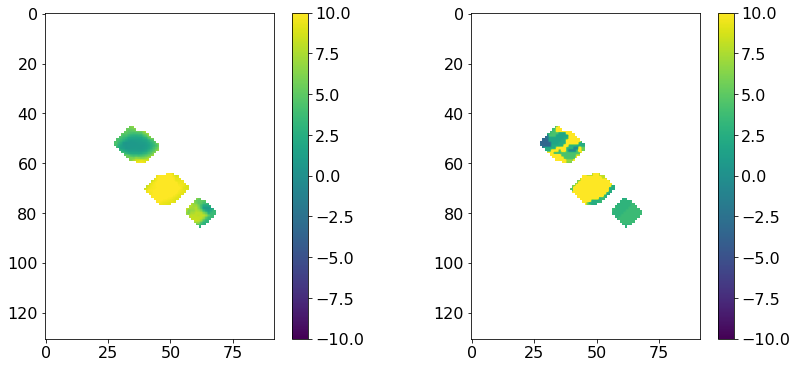

In [122]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes1 if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(reg1).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 70*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()



m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap1 = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

DaskSpectralCube with shape=(3840, 131, 92) and unit=K and chunk size (1280, 131, 92):
 n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
 n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.751233 deg:  -35.750908 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 131, 92) and unit=K and chunk size (1280, 131, 92):
 n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
 n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.751233 deg:  -35.750908 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062723285.979 Hz:220937312964.500 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 131, 92) and unit=K and chunk size (1280, 131, 92):
 n_x:     92  type_x: RA---SIN  unit_x: deg    range:   260.229792 deg:  260.230072 deg
 n_y:    131  type_y: DEC--SIN  unit_y: deg    range:   -35.75123

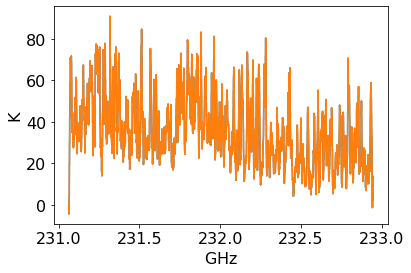

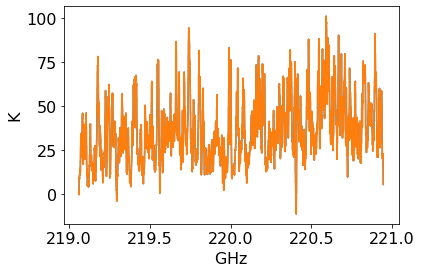

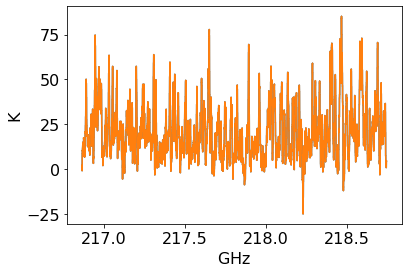

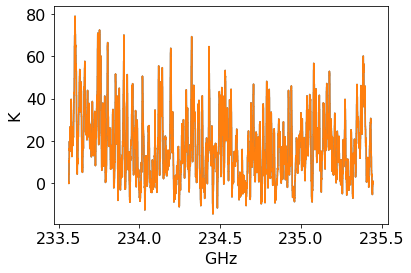

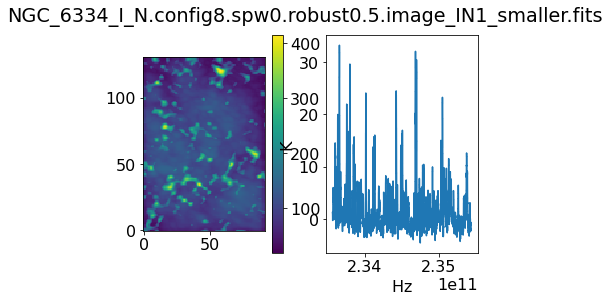

In [123]:
cbflist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_IN1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg1).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_NGC6334INSMA1bd_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap1,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('NGC6334INSMA1bd_vmap1.fits')
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_NGC6334INSMA1bd_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_SMA1bd_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_SMA1bd_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [124]:
ls spectra

figures/
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN1_smaller_SMA1bd_stack.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN1_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN1_smaller_SMA1bd_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN1_smalle

In [125]:
stackspectrasma1bd = []
for ii,fn in enumerate(glob.glob('spectra/*SMA1bd_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    if pysp.unit != u.K:
        pysp.unit = u.K
        pysp.data *= jtok.value
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[2]}_SMA1bd_stack'
    stackspectrasma1bd.append(pysp)

NGC_6334_I_N_spw0_SMA1bd_stack
NGC_6334_I_N_spw3_SMA1bd_stack
NGC_6334_I_N_spw1_SMA1bd_stack
NGC_6334_I_N_spw2_SMA1bd_stack


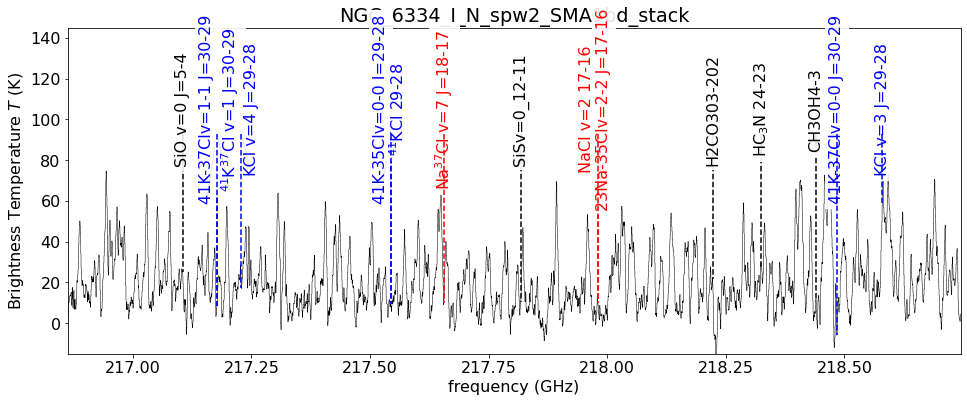

In [126]:
overplot_saltlines(stackspectrasma1bd, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-15, ymax=145)

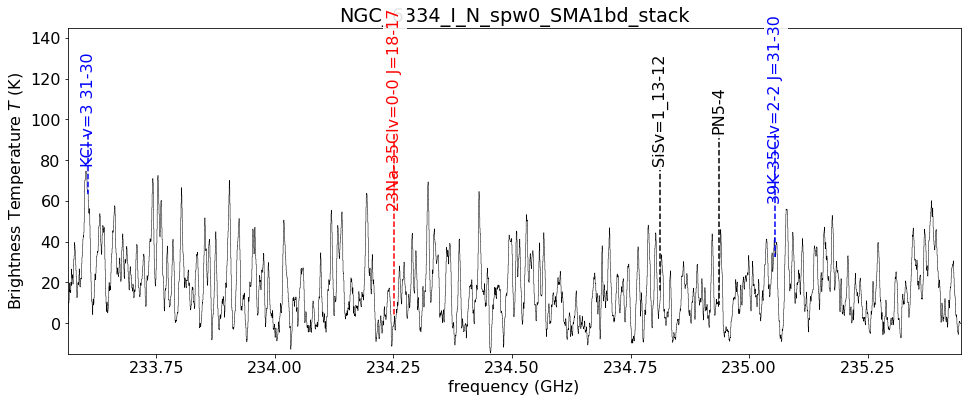

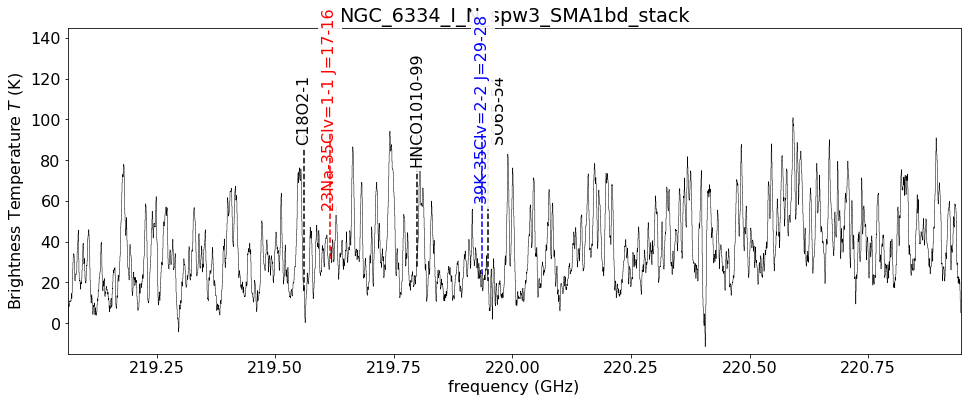

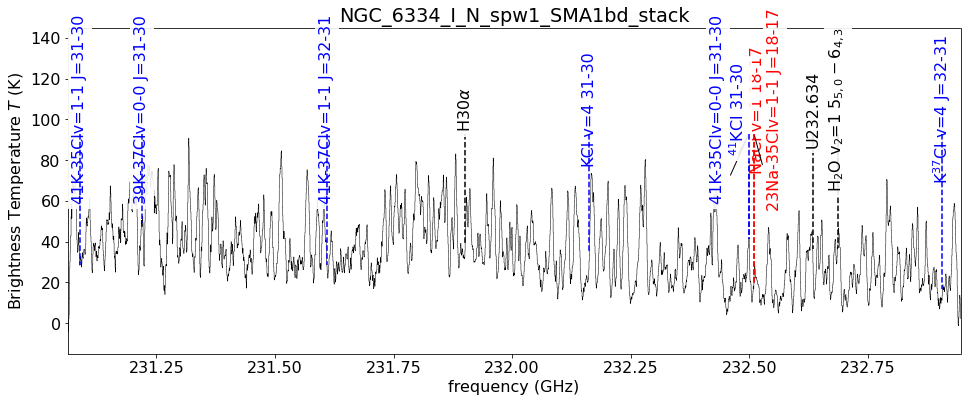

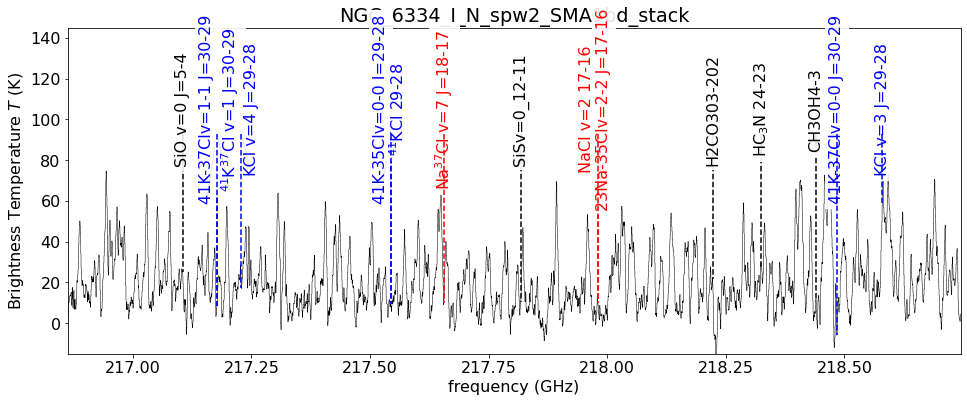

In [127]:
for fn in glob.glob('spectra/figures/color*SMA1bd*stack.png'):
    display(Image(fn))

# Quicker check for candidates

I made region files covering all of the continuum sources.  Just want to have a look at the 'best candidate' lines

In [137]:
import regions
allregs = regions.Regions.read('abunchofregions.reg')

In [138]:
restvals = {0:  234.251912*u.GHz,
 1:  232.6867*u.GHz,
 2:  217.817644*u.GHz,
 3:  219.614936*u.GHz,}

IN-SMA1b-N
DaskVaryingResolutionSpectralCube with shape=(179, 17, 19) and unit=K and chunk size (118, 17, 19):
 n_x:     19  type_x: RA---SIN  unit_x: deg    range:   260.229915 deg:  260.229970 deg
 n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -35.751020 deg:  -35.750980 deg
 n_s:    179  type_s: VRAD      unit_s: km / s  range:      -54.709 km / s:      64.920 km / s
DaskVaryingResolutionSpectralCube with shape=(192, 17, 19) and unit=K and chunk size (192, 17, 19):
 n_x:     19  type_x: RA---SIN  unit_x: deg    range:   260.229915 deg:  260.229970 deg
 n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -35.751020 deg:  -35.750980 deg
 n_s:    192  type_s: VRAD      unit_s: km / s  range:      -54.882 km / s:      65.281 km / s
DaskVaryingResolutionSpectralCube with shape=(181, 17, 19) and unit=K and chunk size (181, 17, 19):
 n_x:     19  type_x: RA---SIN  unit_x: deg    range:   260.229915 deg:  260.229970 deg
 n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -35

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DaskVaryingResolutionSpectralCube with shape=(193, 16, 22) and unit=K and chunk size (193, 16, 22):
 n_x:     22  type_x: RA---SIN  unit_x: deg    range:   260.229776 deg:  260.229841 deg
 n_y:     16  type_y: DEC--SIN  unit_y: deg    range:   -35.751095 deg:  -35.751058 deg
 n_s:    193  type_s: VRAD      unit_s: km / s  range:      -54.745 km / s:      65.240 km / s
87


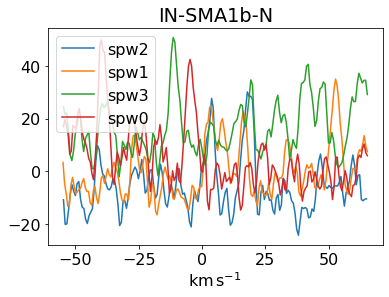

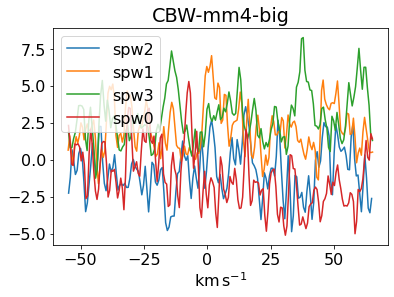

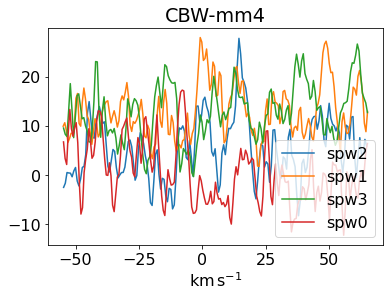

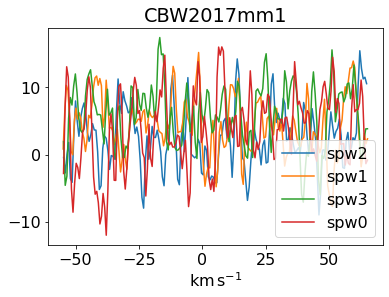

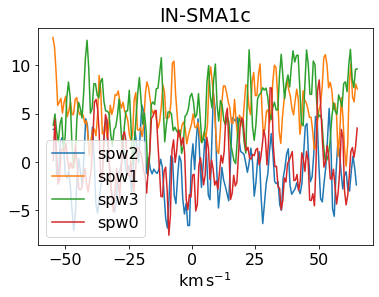

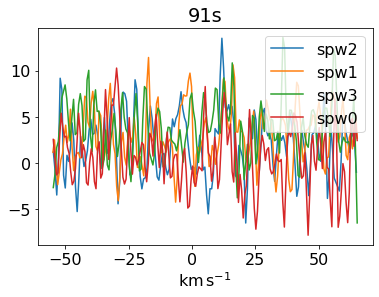

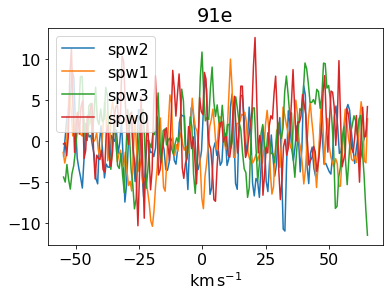

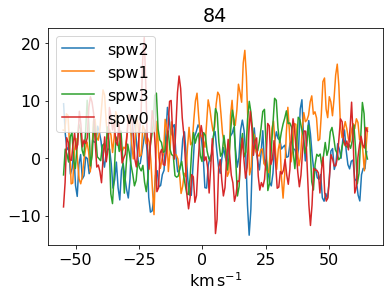

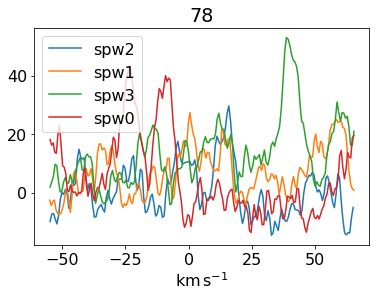

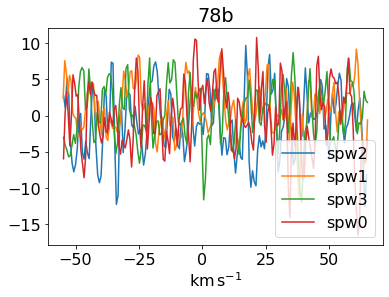

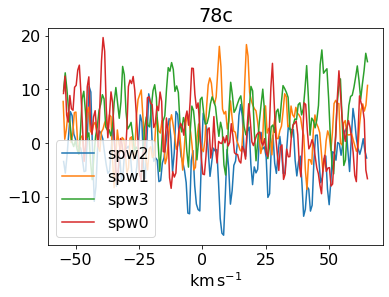

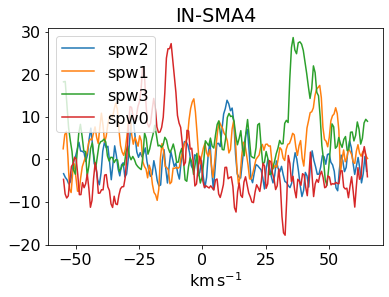

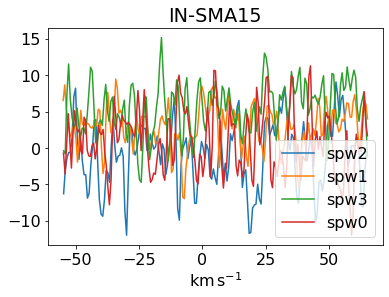

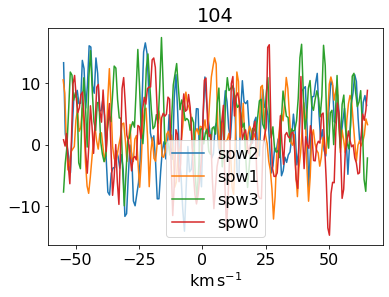

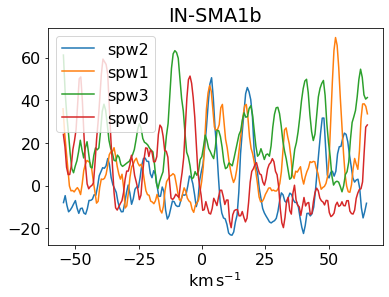

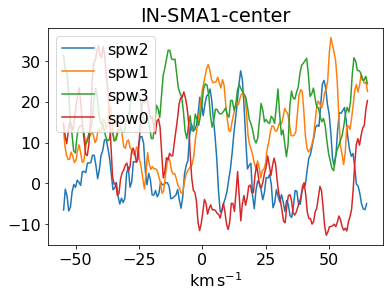

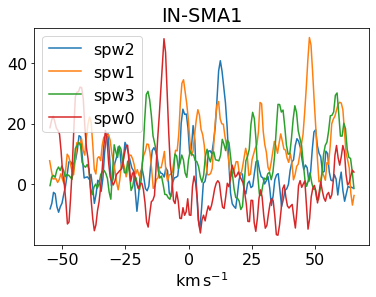

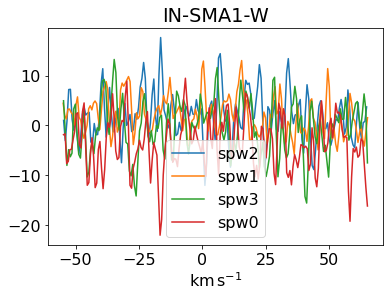

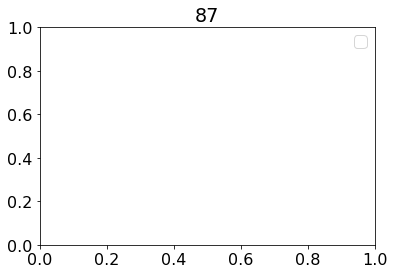

In [145]:
flist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_small.fits'))
fullcubes = [SpectralCube.read(fn, use_dask=True) for fn in flist]
for rreg in allregs:
    text = rreg.meta['text']
    print(text)
    fig = pl.figure()
    for fn,cube in zip(flist, fullcubes):
        spw = fn.split(".")[2]
        spwnum = int(spw[-1])
        try:
            cube = (cube
                    .subcube_from_regions([rreg])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restvals[spwnum])
                    .spectral_slab(vcen-50*u.km/u.s, vcen+70*u.km/u.s)
                    .to(u.K))
        except ValueError as ex:
            continue
        print(cube)
        spec = cube.mean(axis=(1,2))
        
        pl.plot(spec.spectral_axis, spec.value, label=spw)
    pl.legend(loc='best')
    #pl.title(rreg.center.to_string('hmsdms'))
    pl.title(text)

    fig.savefig(f"quick_stack_region_{rreg.meta['text']}.png", bbox_inches='tight')